In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/marcfreir/Documents/DISCOVERY_LAB-PLAYGROUND/discovery_lab-playground_venv/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
import tifffile as tff
import glob
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

# Step 1: Define the dataset class
class SeismicDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        #self.image_paths = glob.glob(root_dir + "/*.tif")
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith('.tif')]

    def is_valid_image(self, img_path):
        try:
            img = tff.imread(img_path)
            if img is None:
                raise IOError(f"Cannot read image {img_path}")
            return True
        except (IOError, SyntaxError):
            return False

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = tff.imread(img_path)
        
        if image.ndim == 2:
            image = np.expand_dims(image, axis=-1)  # Add channel dimension if missing
            image = np.repeat(image, 3, axis=-1)  # Repeat channels to make it 3-channel
        image = transforms.ToPILImage()(image)  # Convert numpy array to PIL Image

        if self.transform:
            image = self.transform(image)

        return image

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [6]:
path = "./data/f3/images"

In [7]:
# Create datasets
train_dataset = SeismicDataset((f'{path}/train'), transform=transform)
val_dataset = SeismicDataset((f'{path}/val'), transform=transform)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
# Step 2: Define a custom feature extractor model
class CustomFeatureExtractor(nn.Module):
    def __init__(self):
        super(CustomFeatureExtractor, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # Adjust input channels as needed
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        return x

In [9]:
feature_extractor = CustomFeatureExtractor().to(device)

In [10]:
# Step 3: Define the BYOL model
class BYOL(nn.Module):
    def __init__(self, base_encoder):
        super(BYOL, self).__init__()
        self.online_network = base_encoder
        self.target_network = base_encoder
        for param_online, param_target in zip(self.online_network.parameters(), self.target_network.parameters()):
            param_target.data.copy_(param_online.data)
            param_target.requires_grad = False
        self.predictor = nn.Sequential(
            nn.Linear(512, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Linear(4096, 512)
        )

    def forward(self, x1, x2):
        o1 = self.online_network(x1)
        o2 = self.online_network(x2)
        t1 = self.target_network(x1).detach()
        t2 = self.target_network(x2).detach()
        p1 = self.predictor(o1)
        p2 = self.predictor(o2)
        return p1, p2, t1, t2

In [11]:
def loss_fn(x, y):
    x = nn.functional.normalize(x, dim=-1, p=2)
    y = nn.functional.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1).mean()

def update_target(online_net, target_net, tau=0.99):
    for param_o, param_t in zip(online_net.parameters(), target_net.parameters()):
        param_t.data = tau * param_t.data + (1 - tau) * param_o.data

byol_model = BYOL(feature_extractor).to(device)

In [12]:
def random_augment(image):
    augmentations = transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor()
    ])
    return augmentations(image)

In [13]:
def train_byol(byol_model, dataloader, epochs=100):
    optimizer = optim.Adam(byol_model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        total_loss = 0
        for images in dataloader:
            #images = [transforms.ToPILImage()(img) for img in images]
            #images = [img.convert("RGB") if img.mode != "RGB" else img for img in images]
            # Convert each image back to PIL and apply random augmentations
            images = [transforms.ToPILImage()(img) for img in images]
            augmented_images1 = torch.stack([random_augment(img) for img in images])
            augmented_images2 = torch.stack([random_augment(img) for img in images])
            augmented_images1 = augmented_images1.to(device)
            augmented_images2 = augmented_images2.to(device)
            optimizer.zero_grad()
            p1, p2, t1, t2 = byol_model(augmented_images1, augmented_images2)
            loss = loss_fn(p1, t2) + loss_fn(p2, t1)
            loss.backward()
            optimizer.step()
            update_target(byol_model.online_network, byol_model.target_network)
            total_loss += loss.item()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader)}')

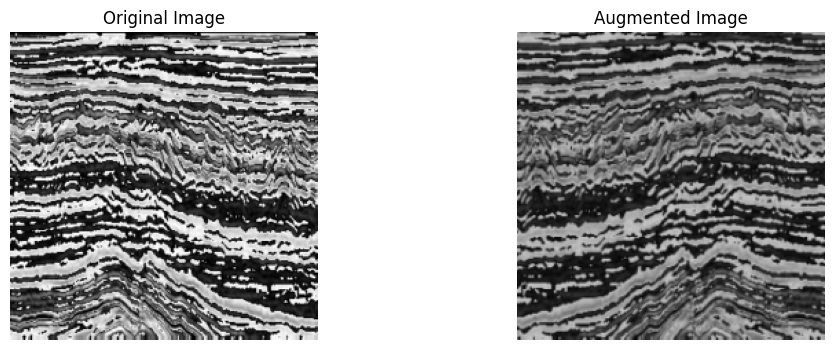

In [14]:
############## TEST
# Assuming 'train_loader' and 'device' are already defined
def plot_augmentation_example(dataloader):
    for images in dataloader:
        # Convert to PIL and apply random augmentations
        original_images = [transforms.ToPILImage()(img) for img in images]
        augmented_images = [random_augment(img) for img in original_images]

        # Plot the first image and its augmented version
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Original image
        axes[0].imshow(original_images[0])
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Augmented image
        augmented_image_np = augmented_images[0].permute(1, 2, 0).numpy()
        axes[1].imshow(augmented_image_np)
        axes[1].set_title('Augmented Image')
        axes[1].axis('off')

        plt.show()
        break  # Only show the first batch for demonstration

# Visualize the first batch of images
plot_augmentation_example(train_loader)
###################

In [15]:
# Train the BYOL model
train_byol(byol_model, train_loader)

Epoch [1/100], Loss: 0.22958486310897336
Epoch [2/100], Loss: 0.09931000201932845
Epoch [3/100], Loss: 0.09686879573329803
Epoch [4/100], Loss: 0.09776171945756482
Epoch [5/100], Loss: 0.09654139703319918
Epoch [6/100], Loss: 0.09850709284505536
Epoch [7/100], Loss: 0.09845932452909407
Epoch [8/100], Loss: 0.0975241776435606
Epoch [9/100], Loss: 0.09567771034855996
Epoch [10/100], Loss: 0.0991950188913653
Epoch [11/100], Loss: 0.09685046442093388
Epoch [12/100], Loss: 0.09736427184074156
Epoch [13/100], Loss: 0.09655050693019744
Epoch [14/100], Loss: 0.09693525298949211
Epoch [15/100], Loss: 0.0988982992787515
Epoch [16/100], Loss: 0.0975256581460276
Epoch [17/100], Loss: 0.09607475419198314
Epoch [18/100], Loss: 0.09696892769105973
Epoch [19/100], Loss: 0.09705976516969743
Epoch [20/100], Loss: 0.09789799490282612
Epoch [21/100], Loss: 0.09573742266624205
Epoch [22/100], Loss: 0.09726285549902147
Epoch [23/100], Loss: 0.09789429172392815
Epoch [24/100], Loss: 0.09651344437753001
Epoch

In [16]:
import torchvision.models as models

model_folder = "trained_model"
model_file = "byol_feature_extractor.pth"

# Specify the path to save the model
save_path = os.path.join(path, model_folder, model_file)
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the trained feature extractor
torch.save(byol_model.online_network.state_dict(), save_path)


print(f"Model saved to {save_path}")

Model saved to ./data/f3/images/trained_model/byol_feature_extractor.pth


In [22]:
# Step 4: Define the segmentation model
class SegmentationHead(nn.Module):
    def __init__(self):
        super(SegmentationHead, self).__init__()
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=28, stride=28)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=4)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)  # Adjust output channels as needed

    def forward(self, x):
        x = torch.relu(self.upconv1(x))
        x = torch.relu(self.upconv2(x))
        x = torch.relu(self.upconv3(x))
        x = self.final_conv(x)
        return x

In [23]:
class SegmentationModel(nn.Module):
    def __init__(self, backbone, segmentation_head):
        super(SegmentationModel, self).__init__()
        self.backbone = backbone
        self.segmentation_head = segmentation_head

    def forward(self, x):
        features = self.backbone(x)
        return self.segmentation_head(features.unsqueeze(-1).unsqueeze(-1))

In [24]:
# Load the trained feature extractor
feature_extractor = CustomFeatureExtractor()
feature_extractor.load_state_dict(torch.load(os.path.join(path, model_folder, model_file)))

segmentation_head = SegmentationHead().to(device)
segmentation_model = SegmentationModel(feature_extractor, segmentation_head).to(device)

In [25]:
# Step 5: Train the segmentation model
def train_segmentation(model, train_loader, val_loader, epochs=100):
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

    return train_losses, val_losses

In [26]:
# Train the segmentation model
train_losses, val_losses = train_segmentation(segmentation_model, train_loader, val_loader)

Epoch [1/100], Train Loss: 0.6935060851035579, Val Loss: 0.692440539598465
Epoch [2/100], Train Loss: 0.6897771569990343, Val Loss: 0.6990634948015213
Epoch [3/100], Train Loss: 0.6832659263764659, Val Loss: 0.6814285963773727
Epoch [4/100], Train Loss: 0.6798703439774052, Val Loss: 0.6799373775720596
Epoch [5/100], Train Loss: 0.6763106123093636, Val Loss: 0.6756339520215988
Epoch [6/100], Train Loss: 0.6704764731468693, Val Loss: 0.6704319715499878
Epoch [7/100], Train Loss: 0.6666345192540076, Val Loss: 0.6677906662225723
Epoch [8/100], Train Loss: 0.6626064239009735, Val Loss: 0.665023609995842
Epoch [9/100], Train Loss: 0.6577178393640826, Val Loss: 0.6608438044786453
Epoch [10/100], Train Loss: 0.6531516717326257, Val Loss: 0.654577761888504
Epoch [11/100], Train Loss: 0.6479727510483034, Val Loss: 0.6576954126358032
Epoch [12/100], Train Loss: 0.6439924893840667, Val Loss: 0.6470821052789688
Epoch [13/100], Train Loss: 0.640160947076736, Val Loss: 0.6527452766895294
Epoch [14/10

In [27]:
import os

segmentation_model_folder = "trained_model"
segmentation_model_file = "byol_segmentation_model.pth"

# Specify the path to save the model
segmentation_save_path = os.path.join(path, segmentation_model_folder, segmentation_model_file)
os.makedirs(os.path.dirname(segmentation_save_path), exist_ok=True)

# Save the trained segmentation model
torch.save(segmentation_model.state_dict(), segmentation_save_path)

print(f"Model saved to {segmentation_save_path}")


Model saved to ./data/f3/images/trained_model/byol_segmentation_model.pth


In [28]:
model_folder = "trained_model"
model_file = "byol_feature_extractor.pth"

# Specify the path to save the model
save_path = os.path.join(path, model_folder, model_file)
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the trained feature extractor
torch.save(byol_model.online_network.state_dict(), save_path)


print(f"Model saved to {save_path}")

Model saved to ./data/f3/images/trained_model/byol_feature_extractor.pth


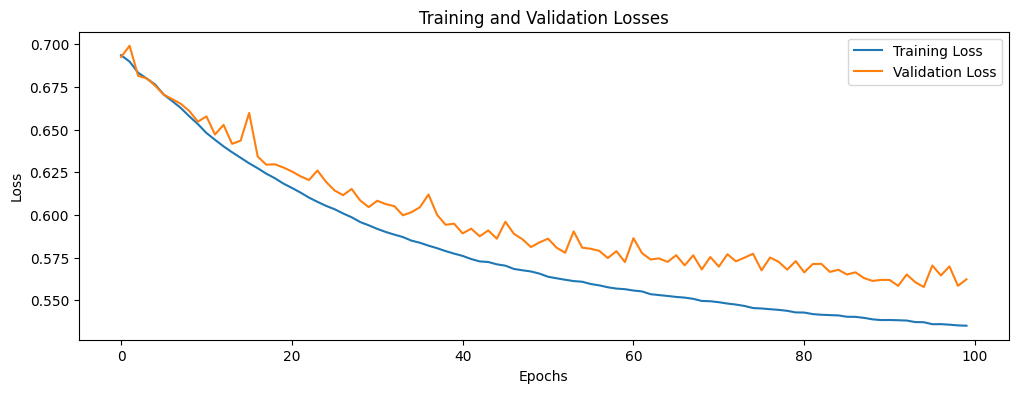

In [29]:
# Plot the training and validation losses
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [30]:
# Step 6: Evaluate the segmentation model
def calculate_metrics(model, dataloader):
    model.eval()
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            labels = images.cpu().numpy()  # Replace with actual labels if available
            outputs = model(images)
            outputs = torch.sigmoid(outputs).cpu().numpy()
            all_outputs.append(outputs)
            all_labels.append(labels)
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_outputs_bin = (all_outputs > 0.5).astype(int)
    all_labels_bin = (all_labels > 0.5).astype(int)
    accuracy = accuracy_score(all_labels_bin.flatten(), all_outputs_bin.flatten())
    precision = precision_score(all_labels_bin.flatten(), all_outputs_bin.flatten(), average='binary')
    recall = recall_score(all_labels_bin.flatten(), all_outputs_bin.flatten(), average='binary')
    f1 = f1_score(all_labels_bin.flatten(), all_outputs_bin.flatten(), average='binary')
    return accuracy, precision, recall, f1

In [31]:
# Calculate metrics on the validation set
accuracy, precision, recall, f1 = calculate_metrics(segmentation_model, val_loader)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.8272932006609462
Precision: 0.8154798438611132
Recall: 0.8038718342236305
F1 Score: 0.8096342341551915


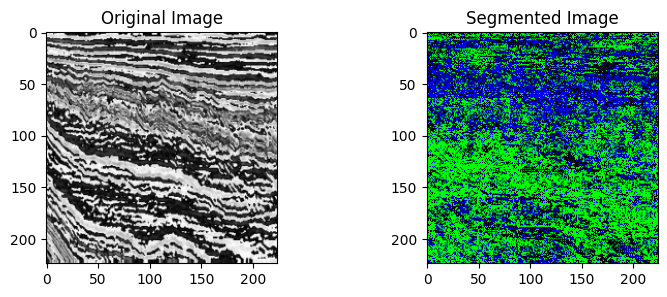

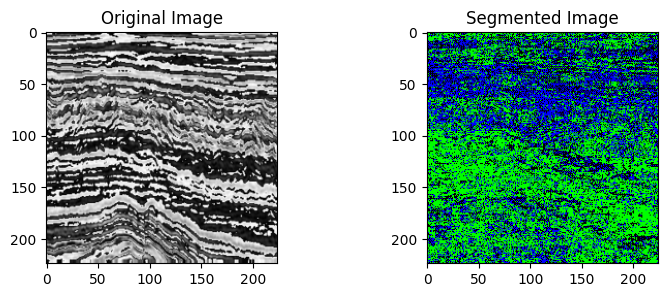

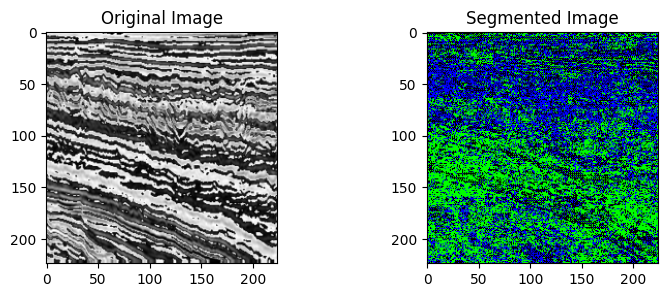

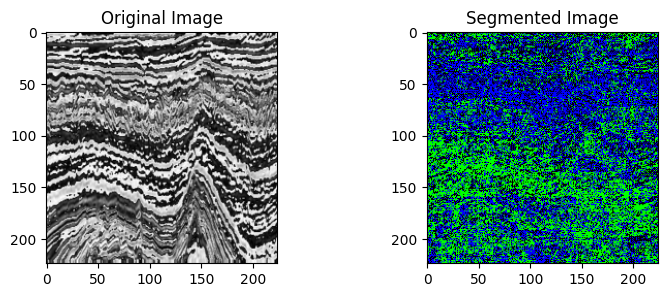

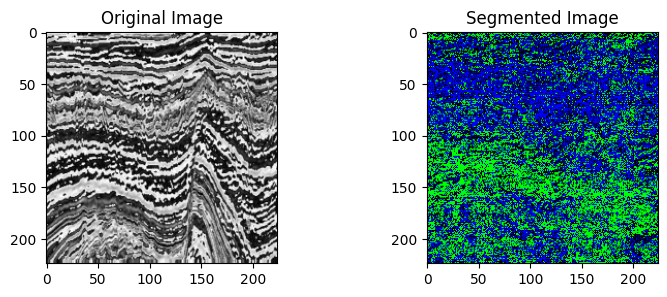

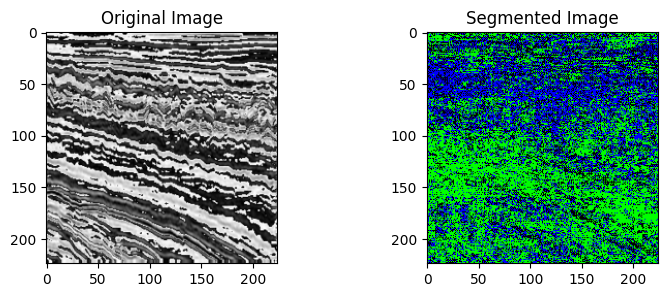

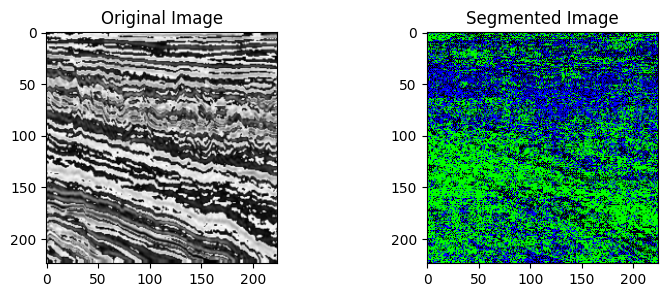

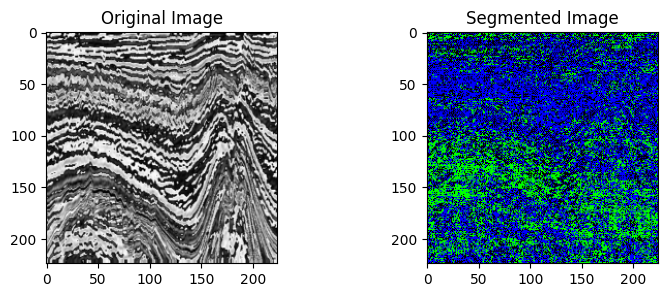

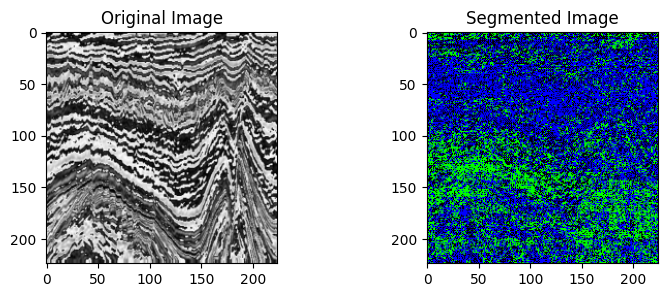

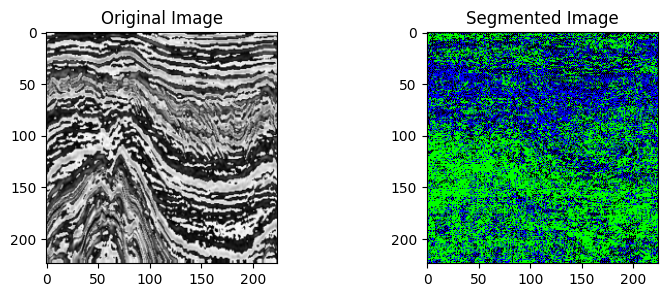

In [32]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define a color palette
color_palette = [
    (0, 0, 0),        # Black for background
    (0, 255, 0),      # Green for segment 1
    (0, 0, 255),      # Blue for segment 2
    (255, 0, 0),      # Red for segment 3
    # Add more colors as needed for additional segments
]

def apply_color_palette(segmented_img, color_palette):
    height, width = segmented_img.shape
    color_img = np.zeros((height, width, 3), dtype=np.uint8)
    for i, color in enumerate(color_palette):
        mask = segmented_img == i  # Assuming segmentation labels are integers
        color_img[mask] = color
    return color_img

def visualize_segmentation(model, dataloader, num_images=10):
    model.eval()
    images_shown = 0
    with torch.no_grad():
        for images in dataloader:
            if images_shown >= num_images:
                break
            images = images.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs).cpu().numpy()
            outputs_bin = np.argmax(outputs, axis=1)  # Convert to single channel label image

            for j in range(len(images)):
                if images_shown >= num_images:
                    break

                input_img = images[j].cpu().permute(1, 2, 0).numpy()
                input_img = (input_img - input_img.min()) / (input_img.max() - input_img.min())  # Normalize image for display

                segmented_img = outputs_bin[j]  # Single channel label image
                color_segmented_img = apply_color_palette(segmented_img, color_palette)

                plt.figure(figsize=(9, 3))
                plt.subplot(1, 2, 1)
                plt.title('Original Image')
                plt.imshow(input_img)
                plt.subplot(1, 2, 2)
                plt.title('Segmented Image')
                plt.imshow(color_segmented_img)
                plt.show()

                images_shown += 1

# Visualize segmentation results
visualize_segmentation(segmentation_model, val_loader)
